In [2]:
import pywt
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from skimage import morphology
from skimage.measure import label, regionprops_table
import pandas as pd
import napari
from napari.utils import nbscreenshot
from scipy.interpolate import make_interp_spline
from sklearn.ensemble import RandomForestClassifier
from dtaidistance import dtw
from collections import defaultdict

## Random Composite Signal Generation

In [3]:
seed = 42
np.random.seed(seed)


n_samples = 500
freq = 5
time = np.linspace(0, 1, n_samples)

* Signal1: gaussian
* Signal2: Cardiac AP
* Signal3: Decreasing Monoexponential

C:\Users\mazo260d\AppData\Local\Temp\ipykernel_15084\2929572496.py:2: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  signal1 = signal.gaussian(30, std=3)


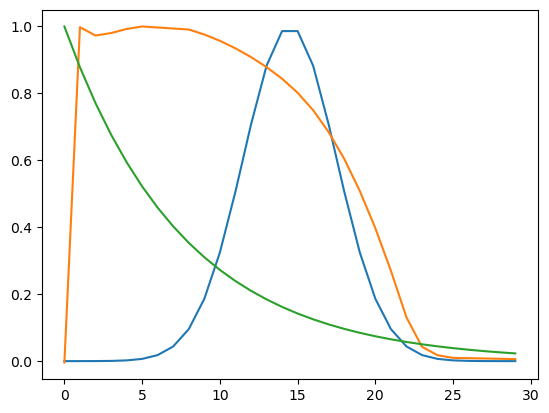

In [4]:
# Signal1: Gaussian
signal1 = signal.gaussian(30, std=3)

# Signal2: Cardiac Ventricular Action Potential
AP_original = np.loadtxt(r"C:\Users\mazo260d\Documents\GitHub\metroid\Simulated_Data\AP.txt",delimiter='\t')
time_sub = np.linspace(0, 5, n_samples) #time vector

# Re-sample at a constant sampling frequency
AP_original[:,0] = AP_original[:,0]/1000                       #ms to sec
xvals = np.arange(AP_original[0,0], AP_original[-1,0], 0.0001) #generate a time vetor with a constant sampling frequency
yinterp = np.interp(xvals, AP_original[:,0], AP_original[:,1]) #interpolate values where original AP time data is missing

# Re-sample by number of samples
yinterp1 = np.interp(time_sub, xvals, yinterp)   #interpolate (extend) data to whole time vector
# Normalize
signal2 = yinterp1
signal2 = signal2+abs(signal2[-1])                          #shift amp from ~-80 to 0
signal2 = signal2/np.amax(signal2)                          #normalize amplitude
# Crop
signal2 = signal2[:30]

# Signal3: Decreasing Monoexponential
def monoexp(x, a, b):
    return a * np.exp(-b * x)
b=0.13
a=1
x = np.arange(30)
signal3 = monoexp(x, a, b)

signals_dict = {0: signal1,
                1: signal2,
                2: signal3}

plt.plot(signal1)
plt.plot(signal2)
plt.plot(signal3)

## Make a random signal composition by adding the three signals with random amplitudes and time shifts

In [5]:
def generate_random_signal_composition(signals_dict, n_samples=500, min_gap=5, max_gap=100):
    composite_signal = np.zeros(n_samples)
    
    position = 0
    while position < n_samples:
        start = position
        # width = np.random.randint(min_width, max(min(max_width, n_samples - position), min_width + 1) + 1)
        signal = signals_dict[np.random.randint(low=0, high=len(signals_dict))]
        width = min(len(signal), n_samples - position)
        composite_signal[start:start+width] = signal[:width]
        position += width + np.random.randint(min_gap, max_gap)  # Move to the end of that window and add some space

    return composite_signal

In [6]:
composite_signal = generate_random_signal_composition(signals_dict=signals_dict)

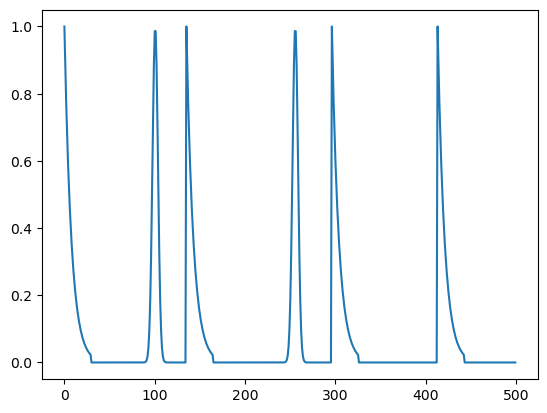

In [7]:
plt.plot(composite_signal)

## Generate random objects

In [8]:
# Generate objects

disk = morphology.disk(4)
square = morphology.square(9)
square[square == 1] = 2
diamond = morphology.diamond(4)
diamond[diamond == 1] = 3
objects_list = [disk, square, diamond]
image = np.zeros((100, 100))
object_order = []
for i in range(10):
    for j in range(3):
        n = np.random.randint(low=2, high=5)
        # obj = objects_list[n]
        obj = morphology.disk(n)
        image[i * 10: i * 10 + (n*2 + 1), 20 + j * 20: 20 + j * 20 + (n*2 + 1)] = obj
        object_order.append(n)

## Add composite signals to objects

In [9]:
# Add signals to label image

label_image = label(image)
height, width = image.shape
time_points = n_samples
time_lapse = np.zeros((time_points, height, width))
for i in range(label_image.max()):
    # print(object_order[i])
    # for label in [1, 2, 3]:
    mask = (label_image == i + 1)  # create boolean mask for current label
    # current_signal = signals[object_order[i]]  # get corresponding signal for current label
    current_signal_category = generate_random_signal_composition(signals_dict)

    # Add random phase by shifting signal
    random_shift = np.random.random()
    current_signal_category = np.roll(current_signal_category, int(random_shift * len(current_signal_category)))

    
    # Add random offset
    current_signal_category = current_signal_category + np.random.random() * 5

    # # Add random window pulses
    # random_windows = generate_random_window_mask()
    # current_signal[~random_windows] = 0

    # Add random noise
    current_signal_category = current_signal_category + np.random.random(size=len(current_signal_category)) / 10

    time_lapse[:, mask] = current_signal_category.reshape((time_points, -1))  # assign signal to region corresponding to current label

## Add mean_intensities of random objects over time to a table

In [10]:
df = pd.DataFrame([])
for i in range(time_points):
    features = regionprops_table(label_image, intensity_image=time_lapse[i], properties=('label', 'mean_intensity'))
    features['frame'] = i
    # data = features.values()
    df = pd.concat([df, pd.DataFrame(features)])

In [11]:
df

,label,mean_intensity,frame
0,1,3.477317,0
1,2,2.538447,0
2,3,1.398264,0
3,4,0.913758,0
4,5,0.505126,0
...,...,...,...
25,26,3.999081,499
26,27,0.277202,499
27,28,0.559926,499
28,29,3.634906,499


## Add data to napari

In [12]:
# viewer = napari.Viewer()
# averages = np.mean(time_lapse, axis=(1, 2))
# viewer.add_image(time_lapse, name='time-lapse')
# table = df

# viewer.add_labels(label_image, features=table, name='labels')

## Annotate some signals

![](./screenshots/signal_annotations1.png)

![](./screenshots/signal_annotations2.png)

In [13]:
# nbscreenshot(viewer)

In [14]:
# nbscreenshot(viewer)

## Save table with annotations to disk

In [72]:
# table = viewer.layers[-1].features

# table.to_csv('table_with_annotations.csv')

table = pd.read_csv('table_with_annotations.csv')
table

,Unnamed: 0,label,mean_intensity,frame,Annotations
0,0,1,3.477317,0,0
1,1,2,2.538447,0,0
2,2,3,1.398264,0,0
3,3,4,0.913758,0,0
4,4,5,0.505126,0,0
...,...,...,...,...,...
14995,14995,26,3.999081,499,0
14996,14996,27,0.277202,499,0
14997,14997,28,0.559926,499,0
14998,14998,29,3.634906,499,0


## Get training data

Get labels where some annotations are present

In [73]:
annotations_mask = table['Annotations'] != 0
labels_with_annotations = np.unique(table[annotations_mask]['label'].values)
labels_with_annotations

array([1, 2, 3], dtype=int64)

In [74]:
# get table rows where label matches labels_with_annotations
table_training = table[table['label'].isin(labels_with_annotations)].sort_values(by=['label', 'frame']).reset_index(drop=True)
table_training

,Unnamed: 0,label,mean_intensity,frame,Annotations
0,0,1,3.477317,0,0
1,30,1,3.499637,1,0
2,60,1,3.433654,2,0
3,90,1,3.455424,3,0
4,120,1,3.434541,4,0
...,...,...,...,...,...
1495,14852,3,1.375912,495,0
1496,14882,3,1.394512,496,0
1497,14912,3,1.449024,497,0
1498,14942,3,1.435429,498,0


## Extract Sub-Signals

In [70]:
class SubSignal:
    def __init__(self, data, category, label, start_frame, end_frame):
        self.data = data  # The signal data
        self.category = category  # The class/annotation of the signal
        self.label = label  # The label of the signal
        self.start_frame = start_frame  # The starting frame of the signal segment
        self.end_frame = end_frame  # The ending frame of the signal segment

    def __repr__(self):
        return f"<SignalSegment category={self.category}, label={self.label}, frames=[{self.start_frame}:{self.end_frame}), data_length={len(self.data)}>"

class SubSignalCollection:
    def __init__(self):
        self.sub_signals = []
        self.categories = []
        self.max_length_per_category = defaultdict(int)

    def add_sub_signal(self, sub_signal):
        self.sub_signals.append(sub_signal)
        if sub_signal.category not in self.categories:
            self.categories.append(sub_signal.category)
        self.max_length_per_category[sub_signal.category] = max(self.max_length_per_category[sub_signal.category], len(sub_signal.data))
    
    def __repr__(self):
        return f"<SubSignalCollection signal categories={self.categories}, number of signals={len(self.sub_signals)}>"
    
    def sort_by_category(self):
        self.sub_signals = sorted(self.sub_signals, key=lambda x: x.category)
    

def extract_sub_signals_by_annotations(df, column_signal_value, column_signal_id, column_signal_annotation, column_frame):
    """
    Extracts sub-signals from a signal data array based on annotations.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing the signal data.
    column_signal_value : str
        The column name containing the signal data.
    column_signal_id : str
        The column name containing the signal ID (usually the label from image).
    column_signal_annotation : str
        The column name containing the signal annotations.
    column_frame : str
        The column name containing the frame information (time).
    
    Returns
    -------
    list
        A list of SignalSegment objects.
    """
    data = df[column_signal_value].values
    annotations = df[column_signal_annotation].values
    labels = df[column_signal_id].values
    frames = df[column_frame].values
    return extract_sub_signals_by_annotations_from_arrays(data, annotations, labels, frames)

# The code below is much slower, it is best to get array and process them than using the DataFrame directly
    # sub_signal_collection = SubSignalCollection()
    # current_signal_category = 0
    # start_index = None
    # annotations = df[column_signal_annotation].values

    # # for i, row in df.iterrows():
    # for i, ann in enumerate(annotations):
    #     if ann > 0:  # Signal detected
    #         if current_signal_category == 0:  # New signal starts
    #             current_signal_category = ann
    #             start_index = i
    #         elif current_signal_category != ann:  # Different signal detected, save previous
    #             # Adjusted to include label and frame information
    #             sub_signal = SubSignal(df[column_signal_value].iloc[start_index:i].values, 
    #                                    current_signal_category, 
    #                                    df[column_signal_id].iloc[start_index], 
    #                                    df[column_frame].iloc[start_index], 
    #                                    df[column_frame].iloc[i])
    #             sub_signal_collection.add_sub_signal(sub_signal)
                
    #             current_signal_category = ann
    #             start_index = i
    #     else:  # Noise detected, save previous signal
    #         if current_signal_category > 0:
    #             sub_signal = SubSignal(df[column_signal_value].iloc[start_index:i].values, 
    #                                    current_signal_category, 
    #                                    df[column_signal_id].iloc[start_index], 
    #                                    df[column_frame].iloc[start_index], 
    #                                    df[column_frame].iloc[i])
    #             sub_signal_collection.add_sub_signal(sub_signal)
                
    #             current_signal_category = 0
    #             start_index = None
    
    # # Handle the case where the last signal goes until the end
    # if current_signal_category > 0:
    #     sub_signal = SubSignal(df[column_signal_value].iloc[start_index:].values, 
    #                                    current_signal_category, 
    #                                    df[column_signal_id].iloc[start_index], 
    #                                    df[column_frame].iloc[start_index], 
    #                                    df[column_frame].iloc[-1])
    #     sub_signal_collection.add_sub_signal(sub_signal)
    
    # return sub_signal_collection

def extract_sub_signals_by_annotations_from_arrays(data, annotations, labels, frames):
    """
    Extracts sub-signals from a signal data array based on annotations.

    Parameters
    ----------
    data : np.ndarray
        The signal data array.
    annotations : np.ndarray
        The annotations array.
    labels : np.ndarray
        The labels array.
    frames : np.ndarray
        The frames array.
    
    Returns
    -------
    list
        A list of SignalSegment objects.
    """
    sub_signal_collection = SubSignalCollection()
    sub_signals_list = []
    current_signal_category = 0
    start_index = None

    for i, ann in enumerate(annotations):
        if ann > 0:  # Signal detected
            if current_signal_category == 0:  # New signal starts
                current_signal_category = ann
                start_index = i
            elif current_signal_category != ann:  # Different signal detected, save previous
                # Adjusted to include label and frame information
                sub_signal = SubSignal(data[start_index:i], 
                                       current_signal_category, 
                                       labels[start_index], 
                                       frames[start_index], 
                                       frames[i])
                sub_signal_collection.add_sub_signal(sub_signal)
                
                current_signal_category = ann
                start_index = i
        else:  # Noise detected, save previous signal
            if current_signal_category > 0:
                sub_signal = SubSignal(data[start_index:i],
                                       current_signal_category,
                                       labels[start_index],
                                       frames[start_index],
                                       frames[i])
                sub_signal_collection.add_sub_signal(sub_signal)
                
                current_signal_category = 0
                start_index = None
    
    # Handle the case where the last signal goes until the end
    if current_signal_category > 0:
        sub_signal = SubSignal(data[start_index:],
                               current_signal_category,
                               labels[start_index],
                               frames[start_index],
                               frames[-1])
        sub_signal_collection.add_sub_signal(sub_signal)
    
    return sub_signal_collection


In [19]:
# Optional small test
# data1 = np.array([0, 1, 2, 0, 0, 3, 4, 5, 0, 6, 0, 1, 2, 0, 0, 0, 6, 0]) # intensity values
# annotations1 = np.array([0, 1, 1, 0, 0, 2, 2, 2, 0, 3, 0, 1, 1, 0, 0, 0, 3, 0])
# label1 = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2])
# frame1 = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8])
# df = pd.DataFrame({'mean_intensity': data1, 'Annotations': annotations1, 'label': label1, 'frame': frame1})

In [20]:
data = table_training['mean_intensity'].values
annotations = table_training['Annotations'].values
labels = table_training['label'].values
frames = table_training['frame'].values

In [75]:
%%timeit
sub_signal_collection = extract_sub_signals_by_annotations(table_training, 'mean_intensity', 'label', 'Annotations', 'frame')

253 µs ± 21 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [22]:
%%timeit
sub_signal_collection = extract_sub_signals_by_annotations_from_arrays(data, annotations, labels, frames)

210 µs ± 13.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [77]:
sub_signal_collection = extract_sub_signals_by_annotations(table_training, 'mean_intensity', 'label', 'Annotations', 'frame')
sub_signal_collection

<SubSignalCollection signal categories=[1, 2, 3], number of signals=17>

## Calculate features for each annotated signal and put them in a table

Sub_signals may have different lengths depending on the user annotations.

In [24]:
sub_signal_collection.max_length_per_category

defaultdict(int, {1: 32, 2: 32, 3: 23})

In [25]:
sub_signal_collection.sub_signals

[<SignalSegment category=1, label=1, frames=[43:74), data_length=31>,
 <SignalSegment category=2, label=1, frames=[117:144), data_length=27>,
 <SignalSegment category=3, label=1, frames=[166:188), data_length=22>,
 <SignalSegment category=2, label=1, frames=[265:297), data_length=32>,
 <SignalSegment category=3, label=1, frames=[325:347), data_length=22>,
 <SignalSegment category=1, label=1, frames=[413:441), data_length=28>,
 <SignalSegment category=1, label=1, frames=[455:487), data_length=32>,
 <SignalSegment category=3, label=2, frames=[17:36), data_length=19>,
 <SignalSegment category=1, label=2, frames=[118:148), data_length=30>,
 <SignalSegment category=3, label=2, frames=[225:248), data_length=23>,
 <SignalSegment category=1, label=2, frames=[285:314), data_length=29>,
 <SignalSegment category=2, label=2, frames=[410:441), data_length=31>,
 <SignalSegment category=1, label=3, frames=[213:245), data_length=32>,
 <SignalSegment category=1, label=3, frames=[286:317), data_length=3

Use spline interpolation to make all sub_signals have the same length under the corresponding category.
Put resampled signals in a table.

In [26]:
def interpolate_samples(signal, n_samples):
    # Resample the signal segment to a fixed number of samples using spline interpolation
    x = np.arange(len(signal))
    x_new = np.linspace(0, len(signal), n_samples)
    spline = make_interp_spline(x, signal, k=3)
    return spline(x_new)

In [27]:
df_resampled = pd.DataFrame([])
for i, sub_signal in enumerate(sub_signal_collection.sub_signals):
    sub_table = pd.DataFrame(interpolate_samples(sub_signal.data, sub_signal_collection.max_length_per_category[sub_signal.category]), columns=['mean_intensity_interpolated'])
    sub_table['sub_label'] = i + 1
    sub_table['original_label'] = sub_signal.label
    sub_table['original_start_frame'] = sub_signal.start_frame
    sub_table['original_end_frame'] = sub_signal.end_frame
    sub_table['frame_resampled'] = np.linspace(sub_signal.start_frame, sub_signal.end_frame, sub_signal_collection.max_length_per_category[sub_signal.category])
    sub_table['category'] = sub_signal.category

    df_resampled = pd.concat([df_resampled, sub_table], axis=0)
df_resampled

,mean_intensity_interpolated,sub_label,original_label,original_start_frame,original_end_frame,frame_resampled,category
0,3.453399,1,1,43,74,43.0,1
1,3.479164,1,1,43,74,44.0,1
2,4.480783,1,1,43,74,45.0,1
3,4.448369,1,1,43,74,46.0,1
4,4.424114,1,1,43,74,47.0,1
...,...,...,...,...,...,...,...
27,1.428026,17,3,448,479,475.0,2
28,1.494664,17,3,448,479,476.0,2
29,1.482570,17,3,448,479,477.0,2
30,1.415668,17,3,448,479,478.0,2


## Extract sub_signal features

use tsfresh to generate sub_signal features table

In [28]:
# tsfresh syntax for extracting features
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters

table_training = df_resampled[['mean_intensity_interpolated', 'sub_label', 'frame_resampled']]

extraction_settings = ComprehensiveFCParameters()

signal_features_table_training = extract_features(table_training, column_id='sub_label', column_sort='frame_resampled',
                     default_fc_parameters=extraction_settings,
                     # we impute = remove all NaN features automatically
                     impute_function=impute)

Feature Extraction: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


In [29]:
signal_features_table_training

,mean_intensity_interpolated__variance_larger_than_standard_deviation,mean_intensity_interpolated__has_duplicate_max,mean_intensity_interpolated__has_duplicate_min,mean_intensity_interpolated__has_duplicate,mean_intensity_interpolated__sum_values,mean_intensity_interpolated__abs_energy,mean_intensity_interpolated__mean_abs_change,mean_intensity_interpolated__mean_change,mean_intensity_interpolated__mean_second_derivative_central,mean_intensity_interpolated__median,...,mean_intensity_interpolated__fourier_entropy__bins_5,mean_intensity_interpolated__fourier_entropy__bins_10,mean_intensity_interpolated__fourier_entropy__bins_100,mean_intensity_interpolated__permutation_entropy__dimension_3__tau_1,mean_intensity_interpolated__permutation_entropy__dimension_4__tau_1,mean_intensity_interpolated__permutation_entropy__dimension_5__tau_1,mean_intensity_interpolated__permutation_entropy__dimension_6__tau_1,mean_intensity_interpolated__permutation_entropy__dimension_7__tau_1,mean_intensity_interpolated__query_similarity_count__query_None__threshold_0.0,mean_intensity_interpolated__mean_n_absolute_max__number_of_maxima_7
1,0.0,0.0,0.0,0.0,128.659991,522.925502,0.081638,0.000426,-0.000185,4.193197,...,0.223718,0.578325,0.871781,1.514278,2.237126,2.682016,2.885083,3.044820,0.0,4.476254
2,0.0,0.0,0.0,0.0,119.999916,452.596621,0.088432,-0.003723,-0.003527,3.652348,...,0.223718,0.443757,0.885289,1.436829,2.195649,2.576443,2.791342,2.844614,0.0,4.202124
3,0.0,0.0,0.0,0.0,87.063424,332.479630,0.106469,-0.012378,-0.005613,3.651149,...,0.836988,0.836988,1.098612,1.388204,1.912304,2.086769,2.260204,2.425480,0.0,4.266921
4,0.0,0.0,0.0,0.0,118.658982,442.293133,0.082028,0.005648,0.003175,3.607866,...,0.223718,0.223718,0.885289,1.477087,2.220018,2.642169,2.936427,3.131334,0.0,4.144616
5,0.0,0.0,0.0,0.0,86.962446,331.818210,0.108708,-0.011320,-0.005008,3.624047,...,0.836988,0.836988,1.098612,1.471689,2.121699,2.360736,2.524168,2.670120,0.0,4.271307
6,0.0,0.0,0.0,0.0,130.225233,535.638883,0.083426,-0.005562,-0.001356,4.296854,...,0.443757,0.443757,0.871781,1.004099,1.342574,1.474108,1.511962,1.551888,0.0,4.484893
7,0.0,0.0,0.0,0.0,127.741764,515.859213,0.079952,-0.001402,-0.000553,4.116691,...,0.443757,0.659872,0.871781,1.534027,2.334285,2.738078,2.791342,2.844614,0.0,4.452759
8,0.0,0.0,0.0,0.0,67.285442,199.789528,0.099756,0.004895,0.003150,2.808775,...,0.836988,0.836988,1.098612,1.167389,1.469453,1.645348,1.825564,2.006955,0.0,3.407073
9,0.0,0.0,0.0,0.0,99.674720,316.317221,0.096000,-0.004351,-0.003514,3.302937,...,0.443757,0.443757,0.871781,1.526806,2.081999,2.340664,2.443028,2.497519,0.0,3.554332
10,0.0,0.0,0.0,0.0,65.447069,189.349288,0.107831,-0.009023,-0.005203,2.700742,...,0.836988,0.836988,1.098612,1.089871,1.487798,1.731026,1.985053,2.165976,0.0,3.351060


Annotations are signal categories

In [30]:
annotations = [sub_sig.category for sub_sig in sub_signal_collection.sub_signals]
annotations


[1, 2, 3, 2, 3, 1, 1, 3, 1, 3, 1, 2, 1, 1, 2, 3, 2]

### Train Classifier

In [31]:
random_state = 42
classifier = RandomForestClassifier(random_state=random_state)
classifier_path = 'sub_signal_classifier.pkl'

# X_train = signal_features_table_training.iloc[:, 1:] # remove the first column (the object_id)

# # imput mean to handle NaN values
# imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean', add_indicator=False)
# X_imputed_train = imputer.fit_transform(X_train)

classifier.fit(signal_features_table_training, annotations)

train_score = classifier.score(signal_features_table_training, annotations)
print(train_score)

1.0


## Detect regions of interest

### Generate a template per category/annotation from the training data.

**For the alignment, consider applying derivative plus low-pass from dtw if signals have non-flat offsets. (check example [here](https://dtaidistance.readthedocs.io/en/latest/usage/clustering.html#k-means-dba-clustering))**

In [46]:
def normalize(signal, method='minmax'):
    if method == 'zscore':
        return (signal - np.mean(signal)) / np.std(signal)
    elif method == 'minmax':
        return (signal - np.min(signal)) / (np.max(signal) - np.min(signal))
    else:
        raise ValueError(f"Unknown normalization method: {method}")

def align_signals(reference, signal):
    alignment = dtw.warping_path_fast(reference, signal)
    
    aligned_signal = np.zeros_like(reference)
    for (i, j) in alignment:
        aligned_signal[i] = signal[j]
    return aligned_signal

# Function to generate template from replicates using median signal as reference
def generate_template_mean(replicates, plot_results=False):

    # Use the median signal as the initial reference
    median_signal = np.median(replicates, axis=0)
    
    # Align all replicates to the median signal
    aligned_replicates = [align_signals(median_signal, rep) for rep in replicates]
    # Optionally plot alignment results
    if plot_results:
        fig, ax = plt.subplots()
        for arep, rep in zip(aligned_replicates, replicates):
            ax.plot(rep, alpha=0.5, color='gray')
            ax.plot(arep, alpha=0.5, color='blue')
    # Compute the average to form the template
    template = np.mean(aligned_replicates, axis=0)
    return template

def generate_templates_by_category(sub_signal_collection, plot_results=False):
    """
    Generate templates by category from a list of SignalSegment objects.
    
    Parameters
    ----------
    sub_signal_collection : SubSignalCollection
        The collection of signal segments.

    """
    # Sort the signal segments by category
    sub_signal_collection.sort_by_category()
    
    # Initialize variables
    templates_by_category = {}
    current_category = None
    sub_signals_with_current_category = []

    # Process each signal segment
    for sub_signal in sub_signal_collection.sub_signals:
        if sub_signal.category != current_category:
            # If the category changes, process the current category
            if sub_signals_with_current_category:
                template = generate_template_mean(sub_signals_with_current_category, plot_results)
                templates_by_category[current_category] = template
                sub_signals_with_current_category = []

            # Update the current category
            current_category = sub_signal.category

        # Normalize and resample the current segment
        target_length = sub_signal_collection.max_length_per_category[current_category]
        resampled_norm_data = interpolate_samples(normalize(sub_signal.data, method='zscore'), target_length)
        sub_signals_with_current_category.append(resampled_norm_data)
    
    # Process the last category
    if sub_signals_with_current_category:
        template = generate_template_mean(sub_signals_with_current_category, plot_results)
        templates_by_category[current_category] = template

    return templates_by_category

Benchmark generate_template functions

In [33]:
replicates_for_benchmark = [interpolate_samples(normalize(sub_signal.data), sub_signal_collection.max_length_per_category[1]) for sub_signal in sub_signal_collection.sub_signals if sub_signal.category == 1]

In [43]:
%%timeit
generate_template_mean(replicates_for_benchmark, plot_results=False)

201 µs ± 4.48 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


generate template function is quite slow (PCA approach deforms signals)

Plot templates and compare them to the original signals

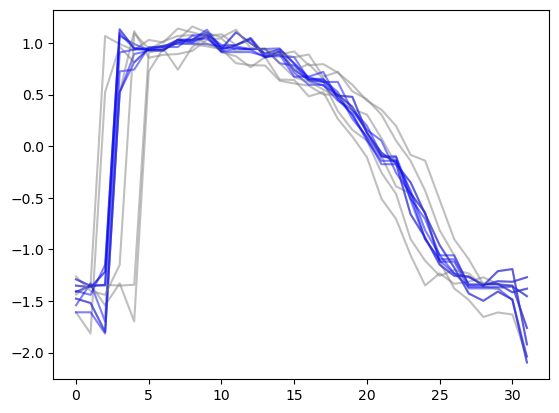

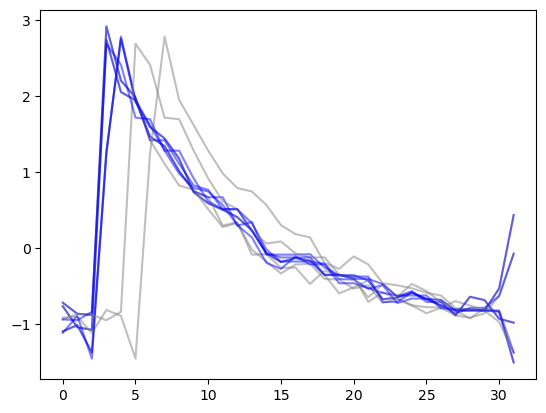

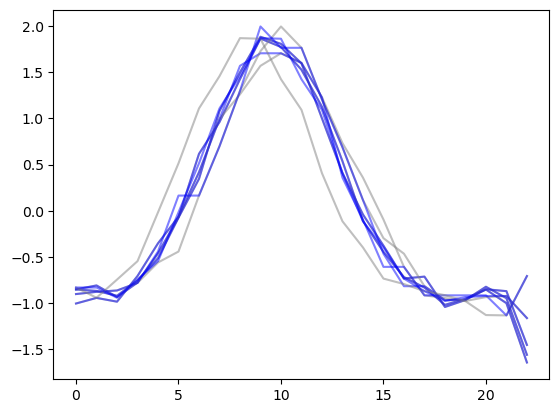

In [47]:
sub_signal_templates = generate_templates_by_category(sub_signal_collection, plot_results=True)

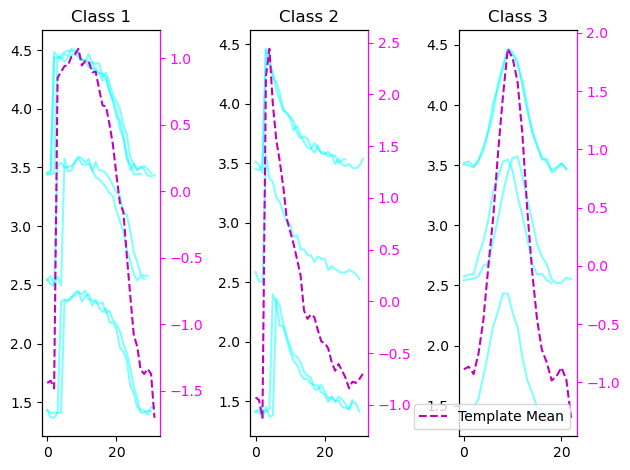

In [48]:
# Plot all signals separated by class in a different column
fig, ax = plt.subplots(1, len(sub_signal_templates))
for sub_sig in sub_signal_collection.sub_signals:
    ax[sub_sig.category-1].plot(sub_sig.data, 'cyan', alpha=0.5)
    ax[sub_sig.category-1].set_title(f'Class {sub_sig.category}')

for i, template_mean in sub_signal_templates.items():
    ax2 = ax[i-1].twinx()
    ax2.yaxis.label.set_color('magenta')
    ax2.tick_params(axis='y', colors='magenta')
    ax2.spines['right'].set_color('magenta')
    ax2.plot(template_mean, 'm--', label='Template Mean')
ax2.legend()
plt.tight_layout()

## Detect regions of interest
Find peaks by thresholding cross-correlation and get a region around them.
Develop some strategy to collect these regions without duplication (or collect duplication, but assign some weight or probability to them)


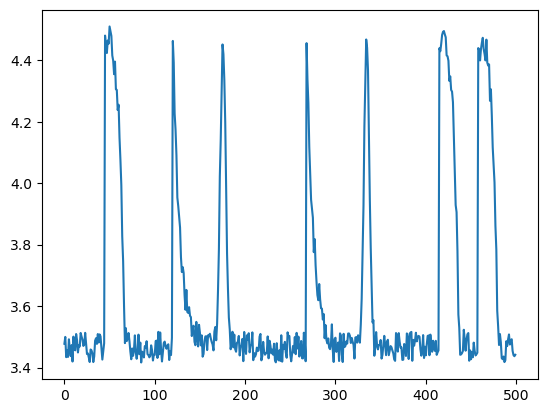

In [49]:
composite_signal1 = table[(table['label'] == 1)].sort_values(by=['label', 'frame']).reset_index(drop=True)['mean_intensity'].values
plt.plot(composite_signal1)

Calculate cross-correlation between each normalized signal class and whole normalized annotated composite signal and plot results

In [50]:
sub_signal_collection.categories

[1, 2, 3]

In [52]:
len(sub_signal_templates)

3

- Options here are:
  - use minmax normalization of signal and template followed by minmax normalization of cross-correlation plus thresholding
  - or zscore normalization of signal and template followed by normalizing cross-correlation by energy of signal and template plus thresholding

## Stopped here

Next steps:
- check whether this is enough to ID sub_signals (no Random Forest Classifier), but it seems not (it detects more sub_signals per category, check the exponential example below, maybe thresholding it differently could solve it)
- if not, train a classifier to detect sub_signals and find a way to assign unique classes to them
- try wavelet transform to detect sub_signals as an alternative to both methods above

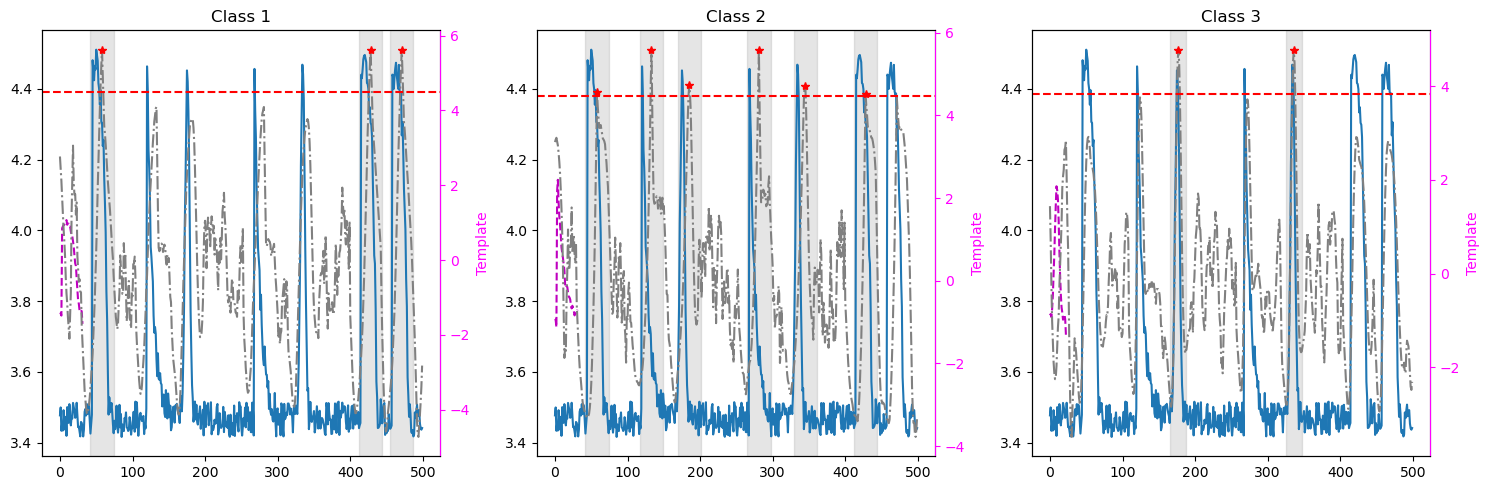

In [57]:
def detect_signal(composite_signal, template, threshold, return_cross_corr=False, norm_method='minmax'):
    composite_signal_norm = normalize(composite_signal, method=norm_method)
    template_norm = normalize(template, method=norm_method)
    cross_corr = signal.correlate(composite_signal_norm, template_norm, mode='same') # default method already chooses between fft and direct

    if norm_method == 'minmax':
         # Normalizing cross-correlation by minmax directly
        normalized_corr = normalize(cross_corr, method=norm_method)
    elif norm_method == 'zscore':
        # Normalizing cross-correlation by energy of signal and template
        fm2 = signal.correlate(composite_signal_norm**2, np.ones_like(template_norm), mode='same') # Convolution of the squared composite signal with a window of ones
        fm = signal.correlate(composite_signal_norm, np.ones_like(template_norm), mode='same') # Convolution of the composite signal with a window of ones
        n = len(template)
        denominator = np.sqrt(fm2 - fm**2/n)
        normalized_corr = cross_corr/denominator

    threshold = np.max(normalized_corr) * threshold
    peaks_indices, _ = signal.find_peaks(normalized_corr, height=threshold)
    if return_cross_corr:
        return peaks_indices, normalized_corr
    return peaks_indices

threshold=0.8
fig, ax = plt.subplots(1, len(sub_signal_templates), figsize=(15, 5))
for i, sub_signal in enumerate(sub_signal_templates.values()):
    peaks_indices, normalized_cross_corr = detect_signal(composite_signal1, sub_signal, threshold, return_cross_corr=True, norm_method='zscore')
    ax[i].plot(composite_signal1, label='Composite Signal')
    ax2 = ax[i].twinx()
    ax2.plot(sub_signal, 'm--', label='Template')
    ax2.yaxis.label.set_color('magenta')
    ax2.tick_params(axis='y', colors='magenta')
    ax2.spines['right'].set_color('magenta')
    ax2.set_ylabel('Template', color='magenta')
    ax2.plot(normalized_cross_corr, '-.', color='gray', label='Normalized Cross-Correlation')
    ax2.plot(peaks_indices, normalized_cross_corr[peaks_indices], 'r*', label='Detected Peaks')
    ax2.axhline(y=np.max(normalized_cross_corr)*threshold, color='r', linestyle='--')
    for peak_index in peaks_indices:
        ax[i].axvspan(peak_index-np.floor(len(sub_signal)/2), peak_index+np.floor(len(sub_signal)/2), color='gray', alpha=0.2)
    ax[i].set_title(f'Class {i+1}')
plt.tight_layout()



In [58]:
sub_signal_templates

{1: array([-1.44125869, -1.42459312, -1.48233273,  0.85291758,  0.89568103,
         0.94009893,  0.94607492,  1.00976692,  1.02594162,  1.06975278,
         0.94470824,  0.97669162,  0.97311459,  0.89345556,  0.89748692,
         0.76768239,  0.6444488 ,  0.63512131,  0.50114542,  0.34717769,
         0.11988629, -0.08780042, -0.15504195, -0.48397805, -0.78650597,
        -1.07826441, -1.16726099, -1.34159138, -1.37348417, -1.33517982,
        -1.37289765, -1.70334747]),
 2: array([-0.92766207, -0.95259972, -1.12509909,  2.17063426,  2.44036325,
         1.90345599,  1.55726063,  1.35285945,  1.11206524,  0.80161049,
         0.67580188,  0.551854  ,  0.4049555 ,  0.25407993, -0.08858336,
        -0.16927896, -0.12560735, -0.15236463, -0.27682318, -0.38760406,
        -0.40293265, -0.45431649, -0.58685263, -0.670224  , -0.60524818,
        -0.66893393, -0.73898279, -0.83912546, -0.77596162, -0.78771831,
        -0.75098324, -0.7009049 ]),
 3: array([-0.88772942, -0.86524808, -0.928254

In [78]:
def extract_sub_signals_by_templates(df, column_signal_value, column_signal_id, column_frame, sub_signal_templates, threshold, method='zscore'):
  
    sub_signal_collection = SubSignalCollection()
    grouped_by_label = df.groupby(column_signal_id, sort=False) # column_signal_id = 'label'
    for label, sub_table in list(grouped_by_label):
        composite_signal = sub_table[column_signal_value].values # column_signal_value = 'mean_intensity'
        # for each composite signal, detect sub_signals using the templates
        for k, template in sub_signal_templates.items():
            peaks_indices = detect_signal(composite_signal, template, threshold, norm_method=method)
            # Collect the sub_signals around each peak
            for peak_index in peaks_indices:
                # Add the sub_signal to the collection with the template category, original label and frame information
                start_index = int(peak_index-np.floor(len(template)/2))
                end_index = int(peak_index+np.floor(len(template)/2))
                # If sub_signal would start before composite signal, set start frame to 0
                if start_index < 0:
                    start_index = 0
                # If sub_signal would end after composite signal, set end frame to the last frame
                if end_index > len(composite_signal):
                    end_index = len(composite_signal)
                sub_signal = SubSignal(composite_signal[start_index:end_index],
                                    k, 
                                    label, 
                                    sub_table[column_frame].values[start_index], 
                                    sub_table[column_frame].values[end_index-1]
                                    )
                sub_signal_collection.add_sub_signal(sub_signal)
    return sub_signal_collection


In [79]:
sub_signal_collection = extract_sub_signals_by_templates(table, 'mean_intensity', 'label', 'frame', sub_signal_templates, threshold)
sub_signal_collection

<SubSignalCollection signal categories=[1, 2, 3], number of signals=350>

Turn collected signals into a table to extract features with tsfresh
No need to resample them since they were collected via template of fixed length

In [80]:
df_resampled = pd.DataFrame([])
for i, sub_signal in enumerate(sub_signal_collection.sub_signals):
    sub_table = pd.DataFrame(sub_signal.data, columns=['mean_intensity'])
    sub_table['sub_label'] = i + 1
    sub_table['original_label'] = sub_signal.label
    sub_table['original_start_frame'] = sub_signal.start_frame
    sub_table['original_end_frame'] = sub_signal.end_frame
    sub_table['frame'] = np.linspace(sub_signal.start_frame, sub_signal.end_frame, len(sub_signal.data))
    sub_table['category'] = 0
    sub_table['template_category'] = sub_signal.category

    df_resampled = pd.concat([df_resampled, sub_table], axis=0)
df_resampled

,mean_intensity,sub_label,original_label,original_start_frame,original_end_frame,frame,cross_corr_peak,category,template_category
0,3.425859,1,1,42,73,42.0,58,0,1
1,3.453399,1,1,42,73,43.0,58,0,1
2,3.479164,1,1,42,73,44.0,58,0,1
3,4.480783,1,1,42,73,45.0,58,0,1
4,4.448369,1,1,42,73,46.0,58,0,1
...,...,...,...,...,...,...,...,...,...
17,1.140673,350,30,219,240,236.0,230,0,3
18,1.079643,350,30,219,240,237.0,230,0,3
19,1.148125,350,30,219,240,238.0,230,0,3
20,1.145647,350,30,219,240,239.0,230,0,3


## Extract sub_signal features for test data

In [81]:
table_test = df_resampled[['mean_intensity', 'sub_label', 'frame']]
table_test.columns = ['mean_intensity_interpolated', 'sub_label', 'frame']

extraction_settings = ComprehensiveFCParameters()

signal_features_table_test = extract_features(table_test, column_id='sub_label', column_sort='frame',
                     default_fc_parameters=extraction_settings,
                     # we impute = remove all NaN features automatically
                     impute_function=impute)

Feature Extraction: 100%|██████████| 39/39 [00:18<00:00,  2.14it/s]


In [82]:
table_test['sub_label'].max()

350

In [83]:
# each row is a different sub_signal (which could be replicates due to the template matching process)
signal_features_table_test

,mean_intensity_interpolated__variance_larger_than_standard_deviation,mean_intensity_interpolated__has_duplicate_max,mean_intensity_interpolated__has_duplicate_min,mean_intensity_interpolated__has_duplicate,mean_intensity_interpolated__sum_values,mean_intensity_interpolated__abs_energy,mean_intensity_interpolated__mean_abs_change,mean_intensity_interpolated__mean_change,mean_intensity_interpolated__mean_second_derivative_central,mean_intensity_interpolated__median,...,mean_intensity_interpolated__fourier_entropy__bins_5,mean_intensity_interpolated__fourier_entropy__bins_10,mean_intensity_interpolated__fourier_entropy__bins_100,mean_intensity_interpolated__permutation_entropy__dimension_3__tau_1,mean_intensity_interpolated__permutation_entropy__dimension_4__tau_1,mean_intensity_interpolated__permutation_entropy__dimension_5__tau_1,mean_intensity_interpolated__permutation_entropy__dimension_6__tau_1,mean_intensity_interpolated__permutation_entropy__dimension_7__tau_1,mean_intensity_interpolated__query_similarity_count__query_None__threshold_0.0,mean_intensity_interpolated__mean_n_absolute_max__number_of_maxima_7
1,0.0,0.0,0.0,0.0,128.619236,522.644601,0.082054,0.000842,-0.001022,4.193197,...,0.443757,0.443757,0.871781,1.534027,2.314690,2.682016,2.885083,3.044820,0.0,4.476254
2,0.0,0.0,0.0,0.0,128.599320,522.667099,0.073211,0.001642,-0.000649,4.209928,...,0.443757,0.443757,0.871781,1.354025,1.796592,2.192132,2.460740,2.627560,0.0,4.474992
3,0.0,0.0,0.0,0.0,128.360506,520.622372,0.079342,-0.000112,0.000086,4.169054,...,0.443757,0.659872,0.871781,1.534027,2.380536,2.898746,2.997793,3.044820,0.0,4.449651
4,0.0,0.0,0.0,0.0,128.619236,522.644601,0.082054,0.000842,-0.001022,4.193197,...,0.443757,0.443757,0.871781,1.534027,2.314690,2.682016,2.885083,3.044820,0.0,4.476254
5,0.0,0.0,0.0,0.0,119.068298,445.499072,0.078970,0.000496,-0.000275,3.592189,...,0.223718,0.223718,0.659872,1.414175,2.238678,2.647685,2.846324,2.948589,0.0,4.175432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,0.0,0.0,0.0,0.0,42.625690,60.334466,0.080137,-0.005709,-0.001620,1.146445,...,0.443757,0.659872,1.079162,1.544247,2.284929,2.728019,2.946449,3.044820,0.0,1.905219
347,0.0,0.0,0.0,0.0,43.824745,62.857128,0.074451,0.003901,0.000253,1.266670,...,0.223718,0.223718,0.871781,1.522700,2.201040,2.642169,2.897668,3.044820,0.0,1.861961
348,0.0,0.0,0.0,0.0,43.195639,60.662755,0.086358,0.000553,-0.000894,1.244148,...,0.223718,0.223718,0.659872,1.541940,2.238678,2.526933,2.679706,2.734198,0.0,1.794374
349,0.0,0.0,0.0,0.0,21.123994,30.214985,0.054745,-0.041718,-0.000185,1.379561,...,0.735622,0.735622,1.667462,1.010100,1.424130,1.767761,1.973001,2.043192,0.0,1.559691


## Predict sub_signal categories

In [84]:
# predict sub_signal categories
predictions = classifier.predict(signal_features_table_test)

In [85]:
predictions

array([1, 1, 1, 1, 2, 2, 2, 2, 1, 3, 3, 1, 1, 2, 1, 2, 1, 2, 3, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 1, 1, 2, 2, 2, 2, 1, 2, 2, 3, 1, 1,
       1, 1, 1, 2, 1, 1, 2, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 3, 2, 2, 2, 1, 1, 1, 1, 2, 2,
       2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 3, 2, 3, 3, 3, 1, 1, 1,
       2, 2, 2, 2, 1, 1, 2, 3, 3, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 3, 3, 3,
       3, 1, 1, 1, 1, 2, 2, 2, 1, 1, 3, 3, 1, 2, 2, 2, 2, 1, 2, 3, 3, 3,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 1, 1, 2, 1, 1, 2, 2,
       2, 3, 3, 3, 3, 1, 2, 2, 2, 2, 1, 2, 3, 3, 3, 3, 1, 1, 2, 2, 2, 2,
       2, 3, 1, 1, 2, 2, 1, 1, 2, 2, 3, 1, 1, 2, 1, 2, 2, 1, 3, 3, 3, 1,
       2, 2, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1,
       2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 3, 3, 3, 3, 3, 3, 1,
       1, 1, 2, 1, 2, 2, 1, 2, 3, 3, 1, 1, 1, 1, 1,

### Evaluate Results for one chosen label

In [99]:
current_label = 30

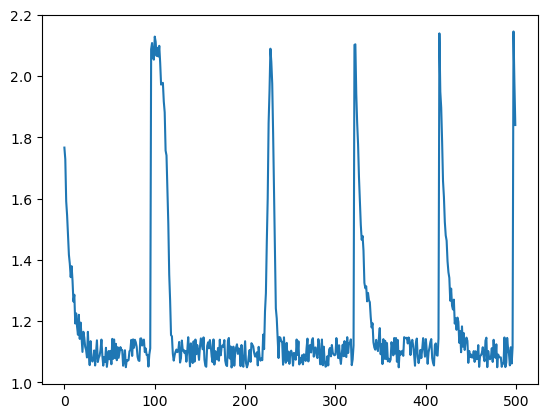

In [100]:
plt.plot(df[df['label'] == current_label]['mean_intensity'].values)

Group by sub_label to add predictions in a matched way

In [104]:
first_row_grouped_by_sub_label = df_resampled.groupby('sub_label').first().reset_index()
first_row_grouped_by_sub_label['predicted_category'] = predictions
first_row_grouped_by_sub_label

,sub_label,mean_intensity,original_label,original_start_frame,original_end_frame,frame,cross_corr_peak,category,template_category,predicted_category
0,1,3.425859,1,42,73,42.0,58,0,1,1
1,2,3.441190,1,412,443,412.0,428,0,1,1
2,3,3.439257,1,455,486,455.0,471,0,1,1
3,4,3.425859,1,42,73,42.0,58,0,2,1
4,5,3.453283,1,117,148,117.0,133,0,2,2
...,...,...,...,...,...,...,...,...,...,...
345,346,1.231819,30,222,253,222.0,238,0,2,2
346,347,1.056382,30,318,349,318.0,334,0,2,2
347,348,1.088830,30,412,443,412.0,428,0,2,2
348,349,1.766683,30,0,14,0.0,4,0,3,2


Filter table by chosen label

In [105]:
current_label_sub_table = first_row_grouped_by_sub_label[first_row_grouped_by_sub_label['original_label'] == current_label]
current_label_sub_table

,sub_label,mean_intensity,original_label,original_start_frame,original_end_frame,frame,cross_corr_peak,category,template_category,predicted_category
342,343,1.051735,30,93,124,93.0,109,0,1,1
343,344,1.766683,30,0,28,0.0,13,0,2,2
344,345,1.051735,30,93,124,93.0,109,0,2,1
345,346,1.231819,30,222,253,222.0,238,0,2,2
346,347,1.056382,30,318,349,318.0,334,0,2,2
347,348,1.088830,30,412,443,412.0,428,0,2,2
348,349,1.766683,30,0,14,0.0,4,0,3,2
349,350,1.072567,30,219,240,219.0,230,0,3,3


Get intersection and union of sub_labels in chosen label

In [214]:
sub_label_array_list = []
categories_list = []
# every label may have a different length
# currently testing for last label (30)
current_label_array_length = len(df[df['label'] == current_label]['mean_intensity'].values)
overlap_array = []
for t_cat, sub_sub_table in list(current_label_sub_table.groupby('template_category')):
    sub_label_array = np.zeros(current_label_array_length)
    for i, row in sub_sub_table.iterrows():
        sub_label_array[int(row['original_start_frame']):int(row['original_end_frame'])] = row['sub_label']
    overlap_array.append(sub_label_array.astype(bool))
    sub_label_array_list.append(sub_label_array)
    categories_list.append(t_cat)
intersection_array = np.sum(np.array(overlap_array).astype(int), axis=0) > 1
union_array = np.sum(np.array(overlap_array).astype(int), axis=0) > 0

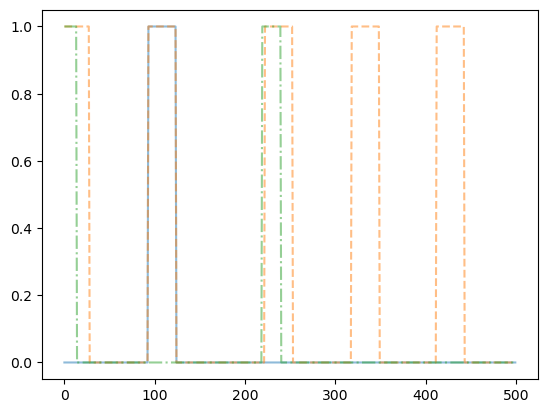

In [225]:
plt.plot(overlap_array[0], alpha=0.5)
plt.plot(overlap_array[1], '--', alpha=0.5)
plt.plot(overlap_array[2], '-.', alpha=0.5)

In [216]:
def get_windows_onsets_and_lengths(overlap_array):
    transition_indices = np.where(
        np.concatenate(
            ([overlap_array[0]], overlap_array[:-1] != overlap_array[1:], [True])
            )
            )[0]
    onsets = transition_indices[:-1:2]
    overlap_lengths = np.diff(transition_indices)[::2]
    return onsets, overlap_lengths

In [217]:
intersection_onsets, intersection_lengths = get_windows_onsets_and_lengths(intersection_array)
union_onsets, union_lengths = get_windows_onsets_and_lengths(union_array)

In [219]:
union_onsets

array([  0,  93, 219, 318, 412], dtype=int64)

In [221]:
union_lengths

array([28, 31, 34, 31, 31], dtype=int64)

In [220]:
intersection_lengths

array([14, 31, 18], dtype=int64)

In [218]:
intersection_onsets

array([  0,  93, 222], dtype=int64)

## Stopped here
Next steps:
- find a way to calculate jaccard index of overlapping sub_signals
- consider sub_labels where jaccard index is higher than threshold as duplicates
  - define a final category for them based on predicitons (if predictions disagree, think what to do...)


In [189]:
sub_label_interse_onsets_list = []
for sub_label_array in sub_label_array_list:
    sub_label_overlap_onsets_list.append(sub_label_array[overlap_onsets])

In [190]:
sub_label_overlap_onsets_list

[array([  0., 343.,   0.]),
 array([344., 345., 346.]),
 array([349.,   0., 350.])]

In [201]:
for values in zip(*sub_label_overlap_onsets_list, overlap_lengths):
    overlap_length = values[-1]
    sub_labels = np.array(values[:-1])
    print(sub_labels)
    sub_labels_that_overlap = sub_labels[sub_labels != 0]
    print(sub_labels_that_overlap)

[  0. 344. 349.]
[344. 349.]
[343. 345.   0.]
[343. 345.]
[  0. 346. 350.]
[346. 350.]


In [158]:
sub_label_array_in_category_dict[1][overlap_onsets]

array([  0., 343.,   0.])

In [159]:
sub_label_array_in_category_dict[2][overlap_onsets]

array([344., 345., 346.])

In [160]:
sub_label_array_in_category_dict[3][overlap_onsets]

array([349.,   0., 350.])

In [162]:
overlap_lengths

array([14, 31, 18], dtype=int64)

In [137]:
overlap_array = np.sum(np.array(overlap_array).astype(int), axis=0) > 1
np.count_nonzero(overlap_array)

array([63], dtype=int64)

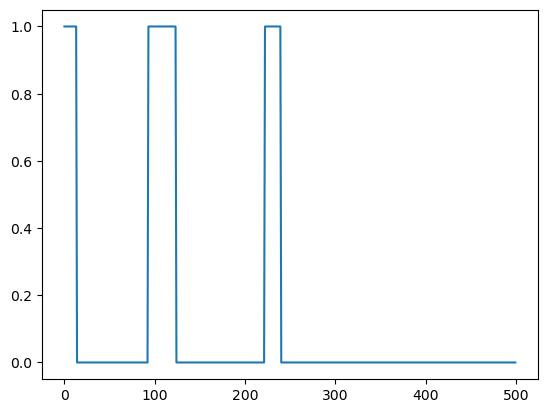

In [144]:
plt.plot(overlap_array)
plt.plot([])

In [139]:
np.concatenate(
            ([overlap_array[0]], overlap_array[:-1] != overlap_array[1:], [True])
            )

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False,

In [145]:
np.where(
        np.concatenate(
            ([overlap_array[0]], overlap_array[:-1] != overlap_array[1:], [True])
            )
            )[0]

array([  0,  14,  93, 124, 222, 240, 500], dtype=int64)

In [141]:
np.diff(
    np.where(
        np.concatenate(
            ([overlap_array[0]], overlap_array[:-1] != overlap_array[1:], [True])
            )
            )[0])[::2]

array([14, 31, 18], dtype=int64)

In [140]:
import numpy as np

def count_consecutive_trues(boolean_array):
    # Ensure the input is a numpy array
    boolean_array = np.asarray(boolean_array)
    
    # Find the positions where the value changes
    changes = np.diff(boolean_array.astype(int))
    
    # Identify the start positions (+1 indicates start of True sequence)
    start_positions = np.where(changes == 1)[0] + 1
    
    # Identify the end positions (+1 indicates end of True sequence)
    end_positions = np.where(changes == -1)[0] + 1
    
    # If the array starts with True, prepend 0 to start_positions
    if boolean_array[0]:
        start_positions = np.r_[0, start_positions]
    
    # If the array ends with True, append the last index to end_positions
    if boolean_array[-1]:
        end_positions = np.r_[end_positions, len(boolean_array)]
    
    # Calculate the lengths of True sequences
    lengths = end_positions - start_positions
    
    return start_positions, lengths

# Example usage
# boolean_array = np.array([False, True, True, False, True, True, True, False, False, True, True])
start_positions, lengths = count_consecutive_trues(overlap_array)

print("Start positions of consecutive True values:", start_positions)
print("Lengths of consecutive True values:", lengths)


Start positions of consecutive True values: [  0  93 222]
Lengths of consecutive True values: [14 31 18]


In [ ]:
# store labels where overlap is larger than

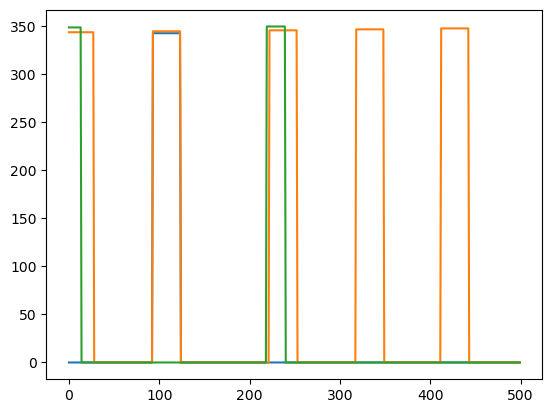

In [111]:
for k, v in sub_label_array_in_category_dict.items():
    
    plt.plot(v, label=f'Template Category {k}')
plt.legend()

In [92]:
sub_sub_table

,sub_label,mean_intensity,original_label,original_start_frame,original_end_frame,frame,cross_corr_peak,category,template_category,predicted_category
342,343,1.051735,30,93,124,93.0,109,0,1,1


In [97]:
predictions[-20:]

array([2, 1, 1, 1, 2, 2, 3, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 3, 2, 2],
      dtype=int64)

Idea
- Expand predicitons column to fill whole table
- For each time-point in each label, give a weighted vote to the category of that time-point based on the predictions (give higher weight to matching detections)

In [77]:
df_resampled['predictions'] = predictions
df_resampled

ValueError: Length of values (469) does not match length of index (12940)

In [ ]:
viewer = napari.Viewer()
# averages = np.mean(time_lapse, axis=(1, 2))
# viewer.add_image(time_lapse, name='time-lapse')
# table = df

# viewer.add_labels(label_image, features=table, name='labels')

## Get all windows where there is a high cross-correlation peak, calculate the same features and add them to the table with annotation class 0

Display wavelet coefficients for each signal

In [23]:
len(signals_by_class[1][0])

31

In [24]:
# First signal of class 1 = signals_by_class[1][0]
waveletname = 'db4'
# Get max level of discrete wavelet
max_level_of_decomposition = pywt.dwt_max_level(len(signals_by_class[1][0]), waveletname)
print(max_level_of_decomposition)


2


In [25]:
def make_list_of_coefficients_names(waveletname, max_level_of_decomposition):
    list_coefficients_names = [waveletname + '_cA_' + str(max_level_of_decomposition)]
    list_coefficients_names += [waveletname + '_cD_' + str(i) for i in range(max_level_of_decomposition, 0, -1)]
    return list_coefficients_names

In [26]:
list_wavelet_coefficients = pywt.wavedec(signals_by_class[1][0], waveletname, level=max_level_of_decomposition)
# list_of_wavelet_decomposition_level_names = make_list_of_coefficients_names(waveletname, max_level_of_decomposition)
list_wavelet_coefficients

[array([8.45641474, 7.2552391 , 9.22873853, 7.6903417 , 7.88126519,
        8.9506319 , 8.90890409, 8.7053209 , 8.47328454, 7.62091933,
        7.04237105, 6.95136322, 6.93967763]),
 array([-0.20218199, -0.5755312 ,  0.53312635, -0.1546327 , -0.00538744,
        -0.00606577, -0.00172286, -0.08456947,  0.08235799, -0.02600053,
         0.00195876, -0.03983206,  0.09999511]),
 array([ 0.17354602,  0.44541506, -0.19104386,  0.02377394, -0.01103984,
        -0.02120041, -0.01753815, -0.04454506, -0.02139769, -0.03030507,
         0.02486697,  0.02785961, -0.04129259, -0.01551608,  0.01455138,
        -0.01677421,  0.01666999, -0.01807835,  0.03788132])]

In [27]:
max_level_of_decomposition2 = pywt.dwt_max_level(len(signals_by_class[2][0]), waveletname)
list_wavelet_coefficients2 = pywt.wavedec(signals_by_class[2][0], waveletname, level=max_level_of_decomposition2)
# list_of_wavelet_decomposition_level_names = make_list_of_coefficients_names(waveletname, max_level_of_decomposition)
list_wavelet_coefficients2

[array([6.37210044, 5.12964851, 4.92683402, 4.73878252, 6.08285418,
        6.02193842, 5.74626209, 5.55677173, 5.41862906, 5.27895748,
        5.20888182, 5.12791821, 5.07815693, 5.07919989, 5.00735282,
        4.98822024, 4.9938421 ]),
 array([ 0.00345871, -0.20618825, -0.14741952,  0.04519063, -0.03351969,
         0.01250238, -0.03145126,  0.03370468, -0.02882155,  0.06726776,
        -0.01056376, -0.0132997 , -0.03085401,  0.01007453, -0.00215131,
         0.03468431,  0.00574862])]

In [28]:
max_level_of_decomposition3 = pywt.dwt_max_level(len(signals_by_class[3][0]), waveletname)
list_wavelet_coefficients3 = pywt.wavedec(signals_by_class[3][0], waveletname, level=max_level_of_decomposition3)
# list_of_wavelet_decomposition_level_names = make_list_of_coefficients_names(waveletname, max_level_of_decomposition)
list_wavelet_coefficients3

[array([5.14557137, 4.96795388, 4.98439313, 4.95892554, 5.00320784,
        5.40136415, 5.87769501, 6.26405175, 6.14095473, 5.61898848,
        5.1713838 , 4.95077739, 4.9455709 , 4.90906561]),
 array([-0.015589  , -0.03433065,  0.02128308,  0.0474797 , -0.00886253,
        -0.03256189,  0.00784702, -0.02863592,  0.00967588, -0.02761624,
         0.03052726, -0.0131998 , -0.01783538,  0.03166538])]

Plot of coefficients for db4 decomposition of signal class 1 (cardiac AP)

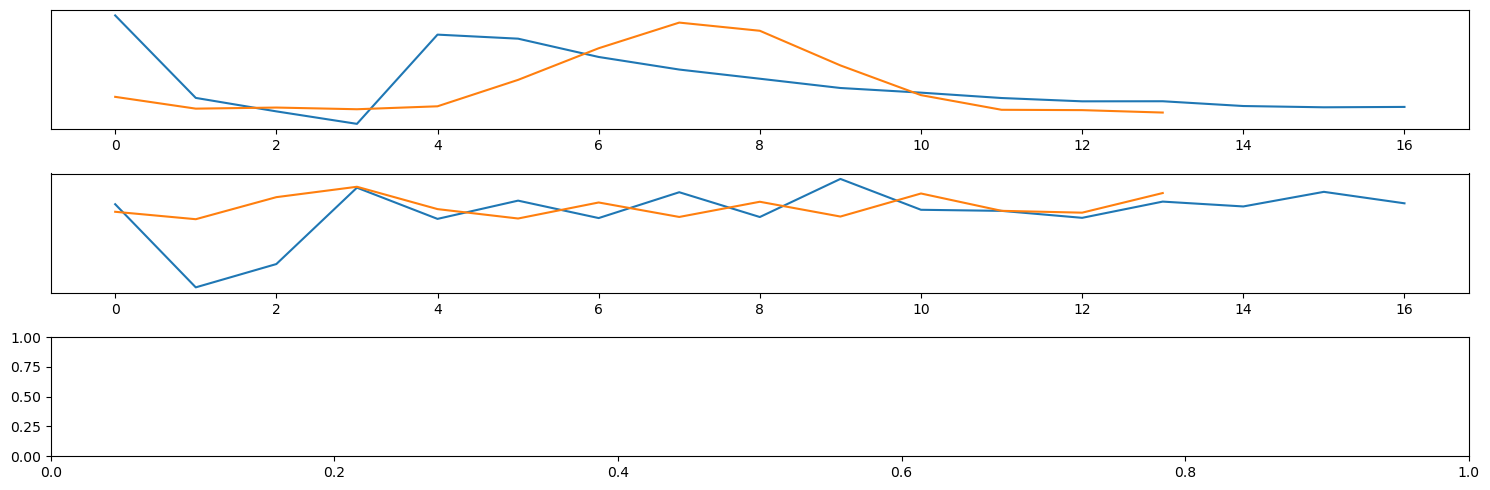

In [30]:
fig, ax = plt.subplots(max_level_of_decomposition + 1, 1, figsize=(15,5))
i=1
# for j, coef in zip(range(len(list_wavelet_coefficients)), list_wavelet_coefficients):
#     # First level is the approximation
#     if j == 0:
#         ax[j].plot(coef, label='label: ' + str(i))
#         ax[j].set_title('Approximation Coefficient.')
#     else:
#         ax[j].plot(coef, label='label: ' + str(i))
#         ax[j].set_title('Detail Coefficient: level ' + str(j) + '.')
#     ax[j].set_yticks([])

for j, coef in zip(range(len(list_wavelet_coefficients2)), list_wavelet_coefficients2):
    # First level is the approximation
    if j == 0:
        ax[j].plot(coef, label='label: ' + str(i))
    else:
        ax[j].plot(coef, label='label: ' + str(i))
    ax[j].set_yticks([])

for j, coef in zip(range(len(list_wavelet_coefficients3)), list_wavelet_coefficients3):
    # First level is the approximation
    if j == 0:
        ax[j].plot(coef, label='label: ' + str(i))
    else:
        ax[j].plot(coef, label='label: ' + str(i))
    ax[j].set_yticks([])

plt.tight_layout()

In [ ]:
a=1

In [ ]:

list_of_coeff_features_table = []
# Get features from wavelet coefficients
for coeff, decomp_level_name in zip(list_wavelet_coefficients, list_of_wavelet_decomposition_level_names):
    coeff_table = pd.DataFrame(coeff, index=signals_table.index)
    coeff_features_table = get_signal_features_table(coeff_table)
    coeff_features_table.columns = [decomp_level_name + '_' +
                                    column_name for column_name in coeff_features_table.columns]
    coeff_features_table.reset_index(inplace=True)
    list_of_coeff_features_table.append(coeff_features_table)

In [60]:
# Get training data
# table_training = table[table['Annotations'] > 0]
# Reshape table, storing one signal per row
signals_table_training = table_training.pivot(
    index='label',
    columns='frame',
    values='mean_intensity')

- get signals with annotations (DONE, currently filtering by specific label ID (to get noise parts as well))
  - get short-signals separated by class (DONE in `signal_by_class`)

  - calculate cross-correlations with composite signal(s) (DONE with one example above)

- caculate wavelets for short-signals

  - calculate cross-correlations of each short-signal decomposition level with corresponding decomposition level of composite signal(s)


- consider thrsholding or features to find potential matches
